#### Before we begin

First the Burgers vector of partial dislocation should be defined, from SAED pattern.

In [193]:
pth_saed = 'WBdisloc/demo/810__x30K.bmp'
image = cv2.imread(pth_saed)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.medianBlur(gray, 5)
centre = []

circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 100,
                            param1=120, param2=30, minRadius=0, maxRadius=0)

if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(image, (x, y), r, (0, 255, 0), 4)
        centre.append([x, y])

# Show the image with the detected circles
cv2.imshow("Detected Circles", image)
cv2.waitKey(0)

# Destroy the window
cv2.destroyAllWindows()

Note that the dislocation image is possibly rotated for $\pi$, so the $b$ should be undergone with the same symmetry operation.

In [191]:
centre

[[680, 572], [920, 998]]

In [198]:
b = np.diff(np.array(centre), axis=0)
b

array([[240, 426]])

###### 2022.12 Author: [wzetto](https://github.com/wzetto)

#### Click the anchor points for initializing the dislocation line detection.

- Left-click to draw points.
- Right-click to redraw the previous one.
- Mid-click to generate interpolated curve.

In [298]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from itertools import product
import scipy
from scipy.optimize import curve_fit
from statsmodels.tools.numdiff import approx_fprime
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import *

In [192]:
pth_wb = 'WBdisloc/demo/810__x30K.bmp'
image = cv2.imread(pth_wb)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

cv2.imshow('image', image)
cv2.waitKey(0)

# Destroy the window
cv2.destroyAllWindows()

In [22]:
image

array([[ 86, 113, 147, ..., 117, 104, 151],
       [124,  87, 127, ..., 114, 115,  87],
       [117,  75, 129, ..., 171, 143, 145],
       ...,
       [135,  83,  80, ...,  69,  67,  91],
       [151,  89, 106, ...,  63,  65,  57],
       [112, 112, 121, ...,  42,  59,  14]], dtype=uint8)

In [167]:
# Create a black image
# image = np.zeros((512, 512, 3), np.uint8)
pth_wb = 'WBdisloc/demo/810__x30K.bmp'
image_anchor = cv2.imread(pth_wb)
image_anchor = cv2.cvtColor(image_anchor, cv2.COLOR_BGR2GRAY)
#* Remove the high-frequency noise.
image_anchor = cv2.GaussianBlur(image_anchor, (3, 3), 0)
image_raw = image_anchor.copy()
# Globally defined variable
points = []
p_inter_, p_inter_pixel = [], []
p_size = 5

def ex_coord(x, y, b_length):
    return [[x+i,y+j] for i, j in product(np.arange(-b_length, b_length+1), repeat = 2)]

# Set up the mouse callback function
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:

        #* Draw black points on the surronding pixels [x+-2, y+-2]
        # cv2.circle(image, (x, y), radius=5, color=0, thickness=3)
        mark_coord = ex_coord(x, y, p_size)
        for item in mark_coord:
            image_anchor[item[1], item[0]] = 0

        cv2.imshow("image", image_anchor)
        points.append([x, y])
        print(f"Left button clicked at ({x}, {y})")

    elif event == cv2.EVENT_RBUTTONDOWN:
        # Remove the point at the location where the mouse is right-clicked
        if len(points) >= 2:
            raw_norm = np.linalg.norm(np.array(points)-np.array([x, y]), axis=1)
        elif len(points) == 1:
            raw_norm = np.linalg.norm(np.array(points)-np.array([x, y]))
        else:
            raise ValueError("Nothing to remove.")

        del_index = np.argmin(raw_norm)

        #* Remove marked points.
        x_, y_ = points[del_index]
        mark_coord_raw = ex_coord(x_, y_, p_size)
        for item_ in mark_coord_raw:
            image_anchor[item_[1], item_[0]] = image_raw[item_[1], item_[0]]

        # cv2.circle(image, (x_, y_), radius=5, color=255, thickness=3)
        cv2.imshow("image", image_anchor)
        points.pop(del_index)

    elif event == cv2.EVENT_MBUTTONDOWN and len(points) > 2:
        
        try:
            for item, pix in zip(p_inter_, p_inter_pixel):
                image_anchor[item[1], item[0]] = pix
            p_inter_.clear()
            p_inter_pixel.clear()
        except:
            pass

        points_ = points.copy()
        p_x = np.linspace(np.min(np.array(points_)[:,0]), np.max(np.array(points_)[:,0]), 1000)
        p_f = interpolate.interp1d(
            np.array(points_)[:,0], np.array(points_)[:,1], kind='quadratic')
        p_y = p_f(p_x)

        p_inter = np.concatenate([p_x.reshape(-1,1), p_y.reshape(-1,1)], axis=1)
        # print(p_inter)
        p_inter = p_inter.astype(np.int32)
        for item in p_inter:
            p_inter_pixel.append(image_raw[item[1], item[0]])
            p_inter_.append(item)

        #* Draw the interpolated line.
        for item in p_inter:
            # print(item)
            image_anchor[item[1], item[0]] = 0
            # cv2.drawMarker(image, (item[0], item[1]),0, markerType=cv2.MARKER_STAR, 
            # markerSize=2, thickness=1, line_type=cv2.LINE_AA)

        cv2.imshow("image", image_anchor)

# Create a window and set the mouse callback function
cv2.namedWindow("image")
cv2.setMouseCallback("image", mouse_callback)

# Show the image and wait for a key press
cv2.imshow("image", image_anchor)
cv2.waitKey(0)

# Destroy the window
cv2.destroyAllWindows()

Left button clicked at (49, 79)
Left button clicked at (1022, 1001)
Left button clicked at (1249, 1003)
Left button clicked at (1248, 996)
Left button clicked at (1248, 996)
Left button clicked at (1247, 1005)
Left button clicked at (1246, 1003)
Left button clicked at (1251, 1004)
Left button clicked at (1028, 1009)
Left button clicked at (1026, 1013)


In [168]:
points

[[1251, 1004], [1026, 1013]]

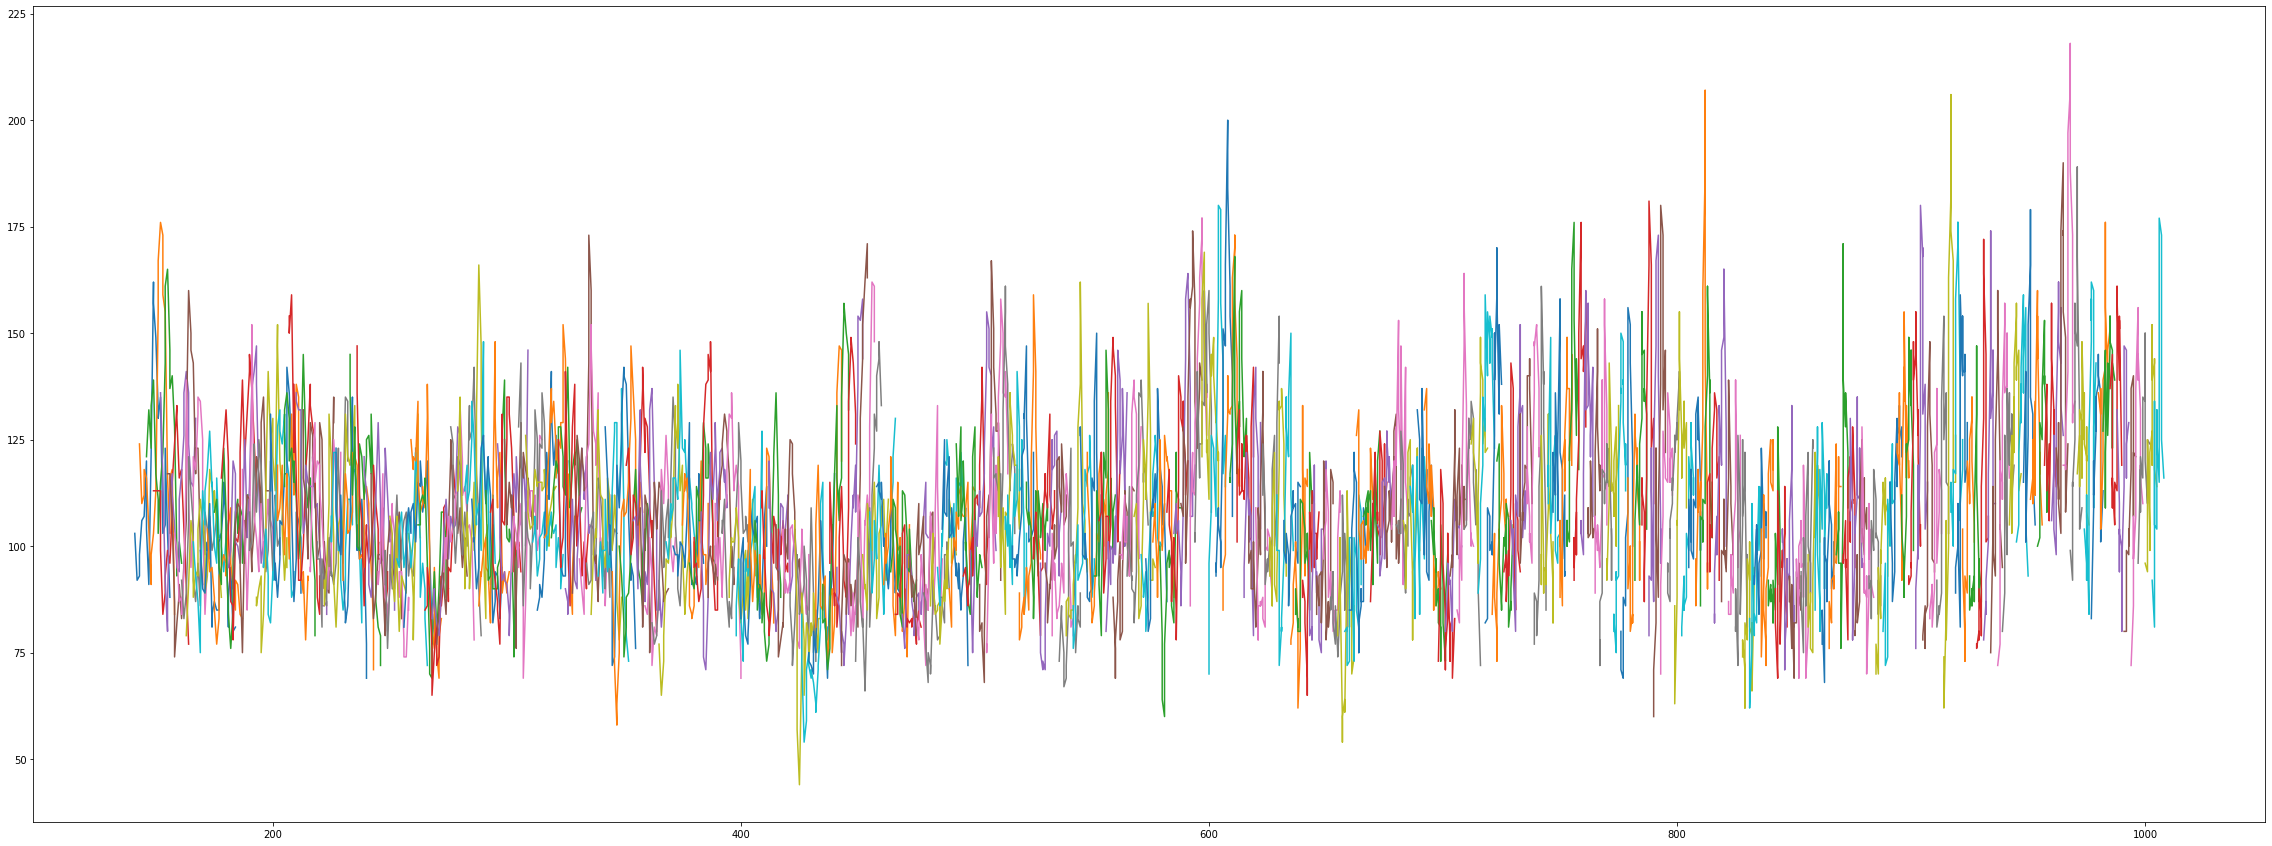

In [160]:
def perpendic_line(p1, p2, p_test):
    x1, y1 = p1
    x2, y2 = p2
    y_mid, x_mid = p_test #* Based on the interpolated points
    # x_mid, y_mid = (x1+x2)/2, (y1+y2)/2
    #* x the horizontal term
    k_vec = (x1-x2)/(y1-y2)
    k_vec_ = -1/k_vec
    y_inter = y_mid - k_vec_*(x_mid)

    return k_vec_, y_inter

def gaussian(x, mu, sigma):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu)**2 / (2 * sigma**2))

image = cv2.imread(pth_wb)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#* Remove the high-frequency noise.
image = cv2.GaussianBlur(image, (3, 3), 0)

points = np.array(points)
#* Generate the interpolated line.
points_ = points.copy()
p_x = np.linspace(np.min(np.array(points_)[:,0]), np.max(np.array(points_)[:,0]), 300)
p_f = interpolate.interp1d(
    np.array(points_)[:,0], np.array(points_)[:,1], kind='quadratic')
p_y = p_f(p_x)
p_inter = np.concatenate([p_x.reshape(-1,1), p_y.reshape(-1,1)], axis=1)

#* Sort the points by y-coordinate
sorted_array = points[points[:, 1].argsort()]
chosen_intensity_list, chosen_intensity_coord = [], []
intensity_list_all, item_list_all = [], []
range_perpendicular = 10 #* Length of interpolated line.
intensity_threshold = 38
mark_point_size = 2
fig, ax = plt.subplots(figsize=(40,15))
len_interline = len(p_inter)

#* Go through the interpolated line between p1 and p2
for p_ind in range(len_interline):

    p1, p2 = p_inter[np.clip(p_ind-10, 0, len_interline-1)], p_inter[np.clip(p_ind+10, 0, len_interline-1)]
    p_mid = p_inter[p_ind].astype(np.int32)
    k_, b_ = perpendic_line(p1, p2, p_mid)
    #* Display the interpolated line
    image[p_mid[1], p_mid[0]] = 0
    
    intensity_list = []
    # p_mid = (p1+p2)/2
    #* Generate the perpendicular vector
    x_test = np.linspace(
        p_mid[1]-range_perpendicular, p_mid[1]+range_perpendicular, range_perpendicular*2+1)
    y_test = k_*x_test + b_
    x_test, y_test = x_test.astype(np.int32), y_test.astype(np.int32)
    perpendicular_line = np.concatenate([x_test.reshape(-1,1), y_test.reshape(-1,1)], axis=1)
    #* y_test as the vertical term, x_test as the horizontal term

    # print(single_p, perpendicular_line)

    for item in perpendicular_line:
        # print(item)
        image[item[0], item[1]] = 0
        #* Through the horizontal axis: item[1]; vertical: item[0]
        intensity_list.append([item[1], image_raw[item[0], item[1]]])

    intensity_list = np.array(intensity_list)

    plt.plot(intensity_list[:,0], intensity_list[:,1])

    #* From now on let's use Gaussian dist. fitting result to determine 
    #* The chosen coordinates.add()
    x_raw = np.arange(1, range_perpendicular*2+2)
    y_raw = intensity_list[:,1]-np.min(intensity_list[:,1])
    y_raw = y_raw/np.sum(y_raw)
    #* Denoise the raw data.
    w_size = 7
    kernel = np.ones(w_size) / w_size
    y_raw_smooth = np.convolve(y_raw, kernel, mode='same')

    popt, pcov = curve_fit(gaussian, x_raw, y_raw_smooth)
    mu, sigma = popt

    model = OLS(y_raw_smooth, gaussian(x_raw, *popt))
    results = model.fit()
    mse = np.var(y_raw_smooth - results.predict(x_raw))

    #* First step: simply take the maximum of intensity list as the 
    #* effective signal.
    ind_max = np.argmax(intensity_list[:,1])
    ind_max = int(mu)
    chosen_intensity = np.max(intensity_list[:,1])-np.min(intensity_list[:,1])

    chosen_intensity_coord.append(perpendicular_line[ind_max])
    chosen_intensity_list.append(chosen_intensity)
    intensity_list_all.append(intensity_list[:,1]) #* The intensity for all
    item_list_all.append(intensity_list[:,0]) #* The coordinates for all

    #* If chosen intensity is greater than the threshold, it will
    #* be marked on the image.
    if mse < intensity_threshold:
        #* Return the index corresponding to the +-0.3 z of fitted GS dist. 
        z_indlist = np.arange(int(mu - 0.3*sigma), int(mu + 0.3*sigma)+1)
        z_indlist = np.unique(np.clip(z_indlist, 0, len(intensity_list)-1))
        for ind in z_indlist:
            mark_coord = ex_coord(
                perpendicular_line[ind][0], perpendicular_line[ind][1], mark_point_size)
            for item in mark_coord:
                image[item[0], item[1]] = 0

intensity_list_all = np.array(intensity_list_all)
item_list_all = np.array(item_list_all)
plt.show()

# Show the image and wait for a key press
cv2.imshow("image", image)
cv2.waitKey(0)

# Destroy the window
cv2.destroyAllWindows()

In [162]:
pth_out = 'WBdisloc/demo/'
cv2.imwrite(pth_out+'/02.png', image)

True

- Collect the intensity-coordinate curve for each *pin*.
- And calculate **AIC**, **BIC**, and **Var** values after fitting a Gaussian distribution for each.
- Then calculate the distribution of **AIC**, **BIC**, **Var** values.

Use the threshold evaluated from the above distributions to extract the effective signal.

AIC: -135.411
BIC: -134.367
MSE: 34.068


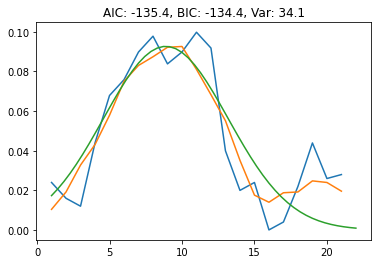

In [297]:
from scipy.optimize import curve_fit
from statsmodels.tools.numdiff import approx_fprime
from statsmodels.regression.linear_model import OLS
import numpy as np

def gaussian(x, mu, sigma):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu)**2 / (2 * sigma**2))

def poisson(k, lamda):
    return (lamda**k * np.exp(-lamda)) / scipy.special.factorial(k)

def binomial(k, n, p):
    return (scipy.special.factorial(n) / (scipy.special.factorial(k) * scipy.special.factorial(n-k))) * p**k * (1-p)**(n-k)

def gamma(x, alpha, beta):
    return (1 / (beta**alpha * scipy.special.gamma(alpha))) * x**(alpha-1) * np.exp(-x/beta)

stats_list = []
single_test = True

for i in range(19,20):
    x_raw = np.arange(1,range_perpendicular*2+2)
    y_raw = intensity_list_all[i]-np.min(intensity_list_all[i])
    y_raw = y_raw/np.sum(y_raw)
    # p = anderson(y_raw, dist='norm')
    #* Denoise the raw data.
    w_size = 5
    kernel = np.ones(w_size) / w_size
    y_raw_smooth = np.convolve(y_raw, kernel, mode='same')

    popt, pcov = curve_fit(gaussian, x_raw, y_raw_smooth)

    model = OLS(y_raw_smooth, gaussian(x_raw, *popt))
    results = model.fit()
    aic = results.aic
    
    bic = results.bic
    
    mse = np.var(y_raw_smooth - results.predict(x_raw))
    
    stats_list.append([aic, bic, mse])

    x_fitted = np.linspace(1,range_perpendicular*2+2,50)
    y_fitted = gaussian(x_fitted, *popt)

    if single_test:
        plt.plot(x_raw, y_raw)
        plt.plot(x_raw, y_raw_smooth)
        plt.plot(x_fitted, y_fitted)

        plt.title(f'AIC: {round(aic,1)}, BIC: {round(bic,1)}, Var: {round(mse,1)}')
        print('AIC: %.3f' % aic)
        print('BIC: %.3f' % bic)
        print('MSE: %.3f' % mse)

if not single_test:
    plt.hist(np.array(stats_list)[:,2], bins=20)
    # plt.hist(np.array(stats_list)[:,1], bins=20)

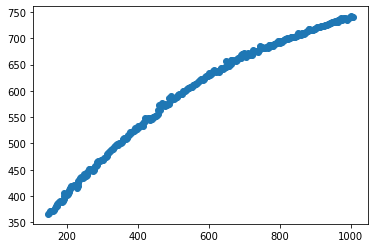

In [163]:
chosen_intensity_coord = np.array(chosen_intensity_coord)
plt.scatter(chosen_intensity_coord[:,1], chosen_intensity_coord[:,0])

In [56]:
class LocalLevel(sm.tsa.statespace.MLEModel):
    _start_params = [1, 1]
    _param_names = ['System_Noise.Q', 'Measurement_Noise.R']

    def __init__(self, endog):
        super(LocalLevel, self).__init__(endog, k_states=1, initialization='diffuse')

        self['design', 0, 0] = 1
        self['transition', 0, 0] = 1
        self['selection', 0, 0] = 1

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, unconstrained):
        return unconstrained**0.5

    def update(self, params, **kwargs):
        params = super(LocalLevel, self).update(params, **kwargs)

        self['state_cov', 0, 0] = params[0]
        self['obs_cov', 0, 0] = params[1]

mod = LocalLevel(chosen_intensity_coord[:,0])
res = mod.fit(full_output=True, maxiter=200)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  300
Model:                     LocalLevel   Log Likelihood                -967.178
Date:                Fri, 30 Dec 2022   AIC                           1940.357
Time:                        13:17:01   BIC                           1951.468
Sample:                             0   HQIC                          1944.804
                                - 300                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
System_Noise.Q         20.7687      3.573      5.813      0.000      13.766      27.771
Measurement_Noise.R     9.6108      1.949      4.931      0.000       5.791      13.431
===================================================================================
Ljung-Box (L1) (Q):                  14.23   Jarque-Bera (JB):                10.36
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               0.88   Skew:                            -0.15
Prob(H) (two-sided):                  0.53   Kurtosis:                         3.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

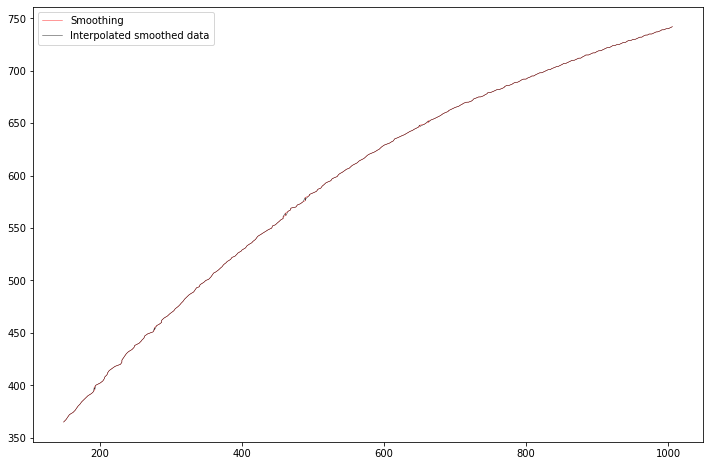

In [231]:
data = chosen_intensity_coord[:,0]
# operate smoothing
smoother = LowessSmoother(smooth_fraction=0.2, iterations=2)
smoother.smooth(data)

# generate intervals
low, up = smoother.get_intervals('prediction_interval', confidence=0.32)
bound = np.concatenate([low.T, up.T], axis=1)
effect_ind = np.array([i for i in range(len(bound)) if data[i] > bound[i][0] and data[i] < bound[i][1]])
abnormal_ind = np.setdiff1d(np.arange(len(bound)), effect_ind)

fig, ax = plt.subplots(figsize=(12,8))

x_coord = chosen_intensity_coord[:,1]
smoothed_data = smoother.smooth_data[0]

#* Interpolate the smoothed data
p_x = np.linspace(np.min(np.array(x_coord)), np.max(np.array((x_coord))), 5000)
p_f = interpolate.interp1d(
    x_coord, smoothed_data, kind='slinear')
p_y = p_f(p_x)

# plt.scatter(x_coord[effect_ind], chosen_intensity_coord[effect_ind,0], s=10,
#             c='b', marker='o', label='effect')
# plt.scatter(x_coord[abnormal_ind], chosen_intensity_coord[abnormal_ind,0], s=10, c='r',
#             marker='x', label='abnormal')
plt.plot(x_coord, smoothed_data, label='Smoothing', color='r', alpha=0.8, linewidth=0.5)
# plt.fill_between(x_coord, low[0], up[0], alpha=0.3, color='r', label='68%')
plt.plot(p_x, p_y, label='Interpolated smoothed data', color='k', alpha=0.8, linewidth=0.5)

plt.legend()
plt.show()

Store the obtained data points

In [157]:
disloc_info = {'upper':{}, 'lower':{}}

In [158]:
disloc_info['upper']['chosen_intensity_coord'] = chosen_intensity_coord
disloc_info['upper']['effect_ind'] = effect_ind
disloc_info['upper']['abnormal_ind'] = abnormal_ind
disloc_info['upper']['bound'] = bound 
disloc_info['upper']['smoothed_data'] = smoother.smooth_data[0]

In [165]:
disloc_info['lower']['chosen_intensity_coord'] = chosen_intensity_coord
disloc_info['lower']['effect_ind'] = effect_ind
disloc_info['lower']['abnormal_ind'] = abnormal_ind
disloc_info['lower']['bound'] = bound 
disloc_info['lower']['smoothed_data'] = smoother.smooth_data[0] 

In [170]:
disloc_info['gauge'] = [points, 200] #* Store the mesurement

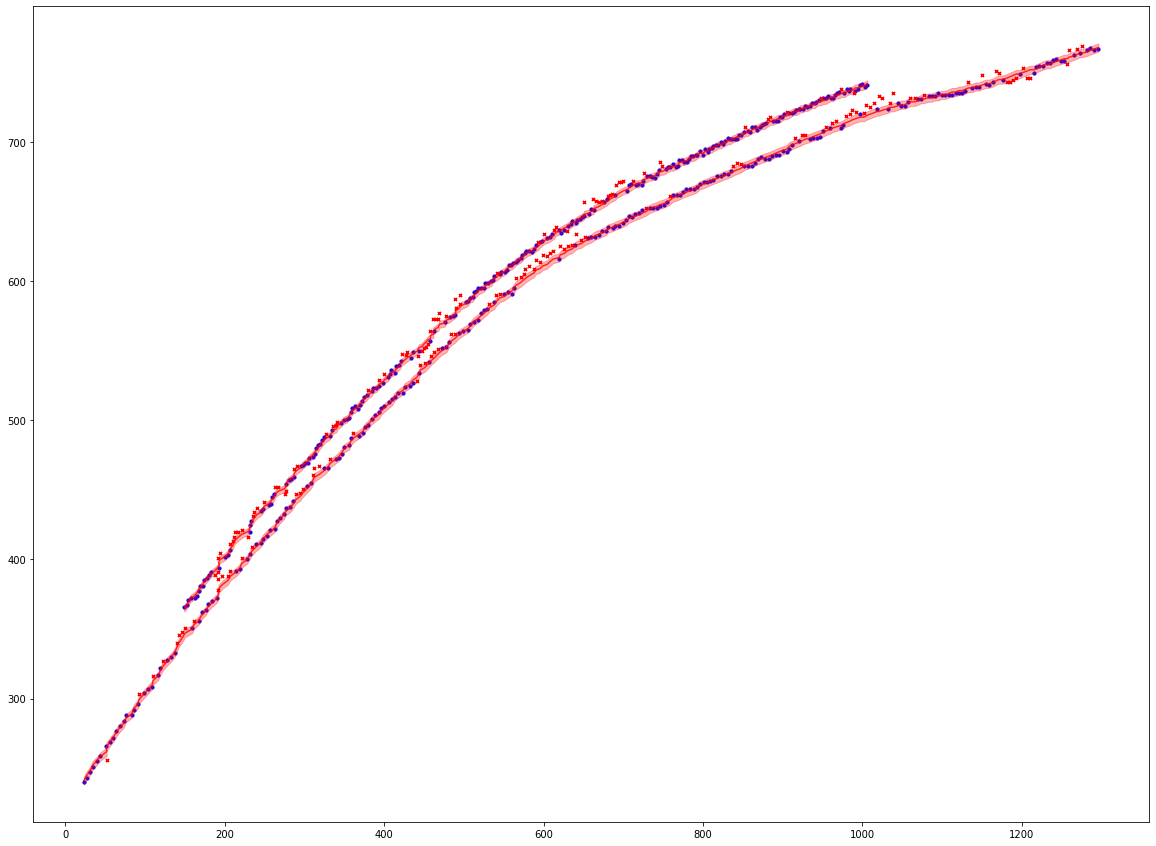

In [240]:
def draw_dislocplot():
    # fig, ax = plt.subplots(figsize=(20,15))

    for label_ in ['upper', 'lower']:
        chosen_intensity_coord = disloc_info[label_]['chosen_intensity_coord'].copy()
        smoothed_data = disloc_info[label_]['smoothed_data'].copy()
        effect_ind = disloc_info[label_]['effect_ind'].copy()
        abnormal_ind = disloc_info[label_]['abnormal_ind'].copy()
        bound = disloc_info[label_]['bound'].copy()
        low, up = bound[:,0], bound[:,1]

        x_coord = chosen_intensity_coord[:,1]

        #* Interpolate the smoothed data
        p_x = np.linspace(np.min(np.array(x_coord)), np.max(np.array((x_coord))), 5000)
        p_f = interpolate.interp1d(
            x_coord, smoothed_data, kind='linear')
        p_y = p_f(p_x)
        
        plt.scatter(x_coord[effect_ind], chosen_intensity_coord[effect_ind,0], s=10,
                    c='b', marker='o', label='effect')
        plt.scatter(x_coord[abnormal_ind], chosen_intensity_coord[abnormal_ind,0], s=10, c='r',
                    marker='x', label='abnormal')
        plt.plot(x_coord, smoothed_data, label='Smoothing', color='r', alpha=0.8)
        plt.fill_between(x_coord, low, up, alpha=0.3, color='r', label='68%')

    # plt.legend()
    # plt.show()

fig, ax = plt.subplots(figsize=(20,15))
draw_dislocplot()
plt.show()

Pixel per nm

In [175]:
points, length = disloc_info['gauge']
pix_per_nm = abs(points[0][0]-points[1][0])/length
pix_per_nm

1.125

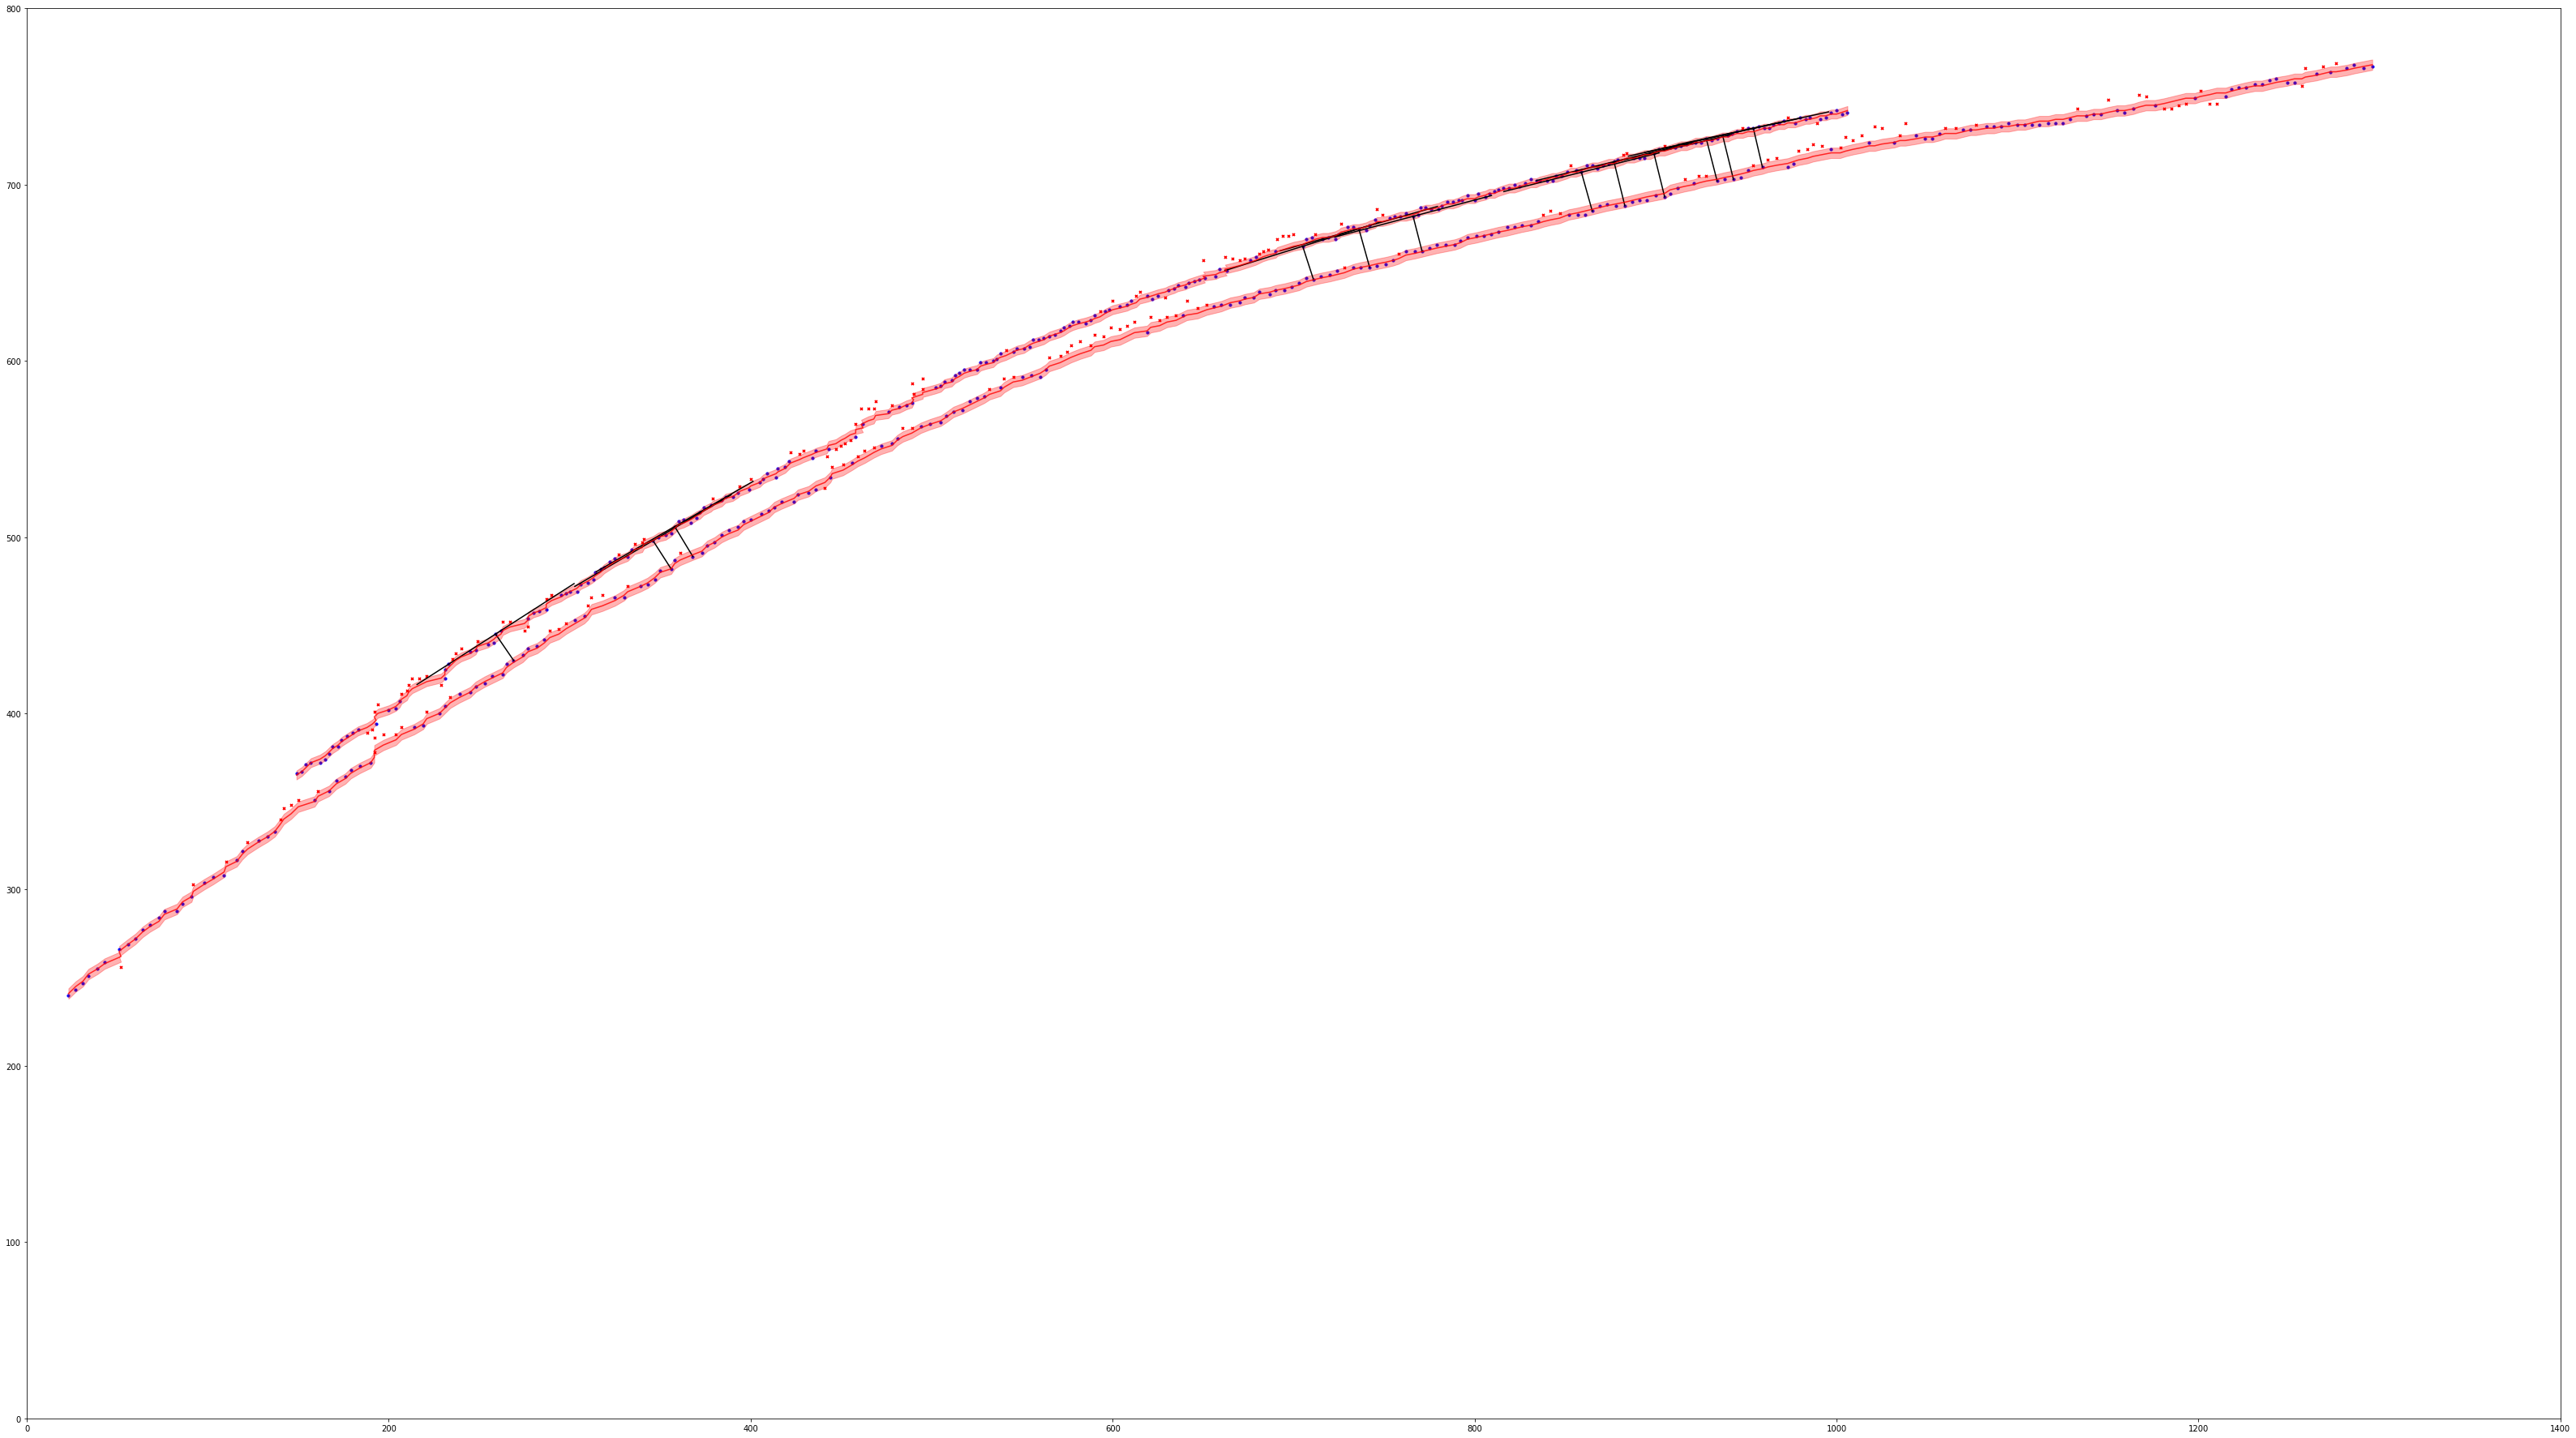

In [290]:
'''
Select the one which has less anchor points as the base dislocation line, l1.
For each point i on l1:

    Calculate tangent vector ai of point i on l1

    Do nearest-neighbor search on
        Points of l2, return point {j1, ..., jm}.

        Calculate angle between vector ai and vector aj in matrix {{i,j1},..., {i,jm}}.
        return matrix abs({theta_1, ..., theta_m} - 90)

        for theta in matrix:
            if theta < epsilon:
                calculate angle theta between b and i->j
                return {i, j1, j2, d, theta}
'''

def theta(v1, v2, for_measure=False):
    dot = np.dot(v1, v2)
    length1 = np.linalg.norm(v1)
    length2 = np.linalg.norm(v2)
    # Compute the angle in radians
    angle = np.arccos(dot / (length1 * length2))
    # Convert to degrees
    angle_degrees = np.degrees(angle)

    if for_measure:
        if angle_degrees >= 90:
            angle_degrees = 180 - angle_degrees
    
    try:
        return angle_degrees[0]
    except:
        return angle_degrees

def tangent_ensemble(base_ind, repeat, p_left, p_right):
    ind_list = np.zeros((repeat*2, 2))
    for i in range(-repeat, repeat):
        ind_list[i+repeat] = np.array([base_ind+i-p_left, base_ind+i+p_right])
    return ind_list.astype(np.int32)

#* Lower
chosen_intensity_coord_lower = disloc_info['lower']['chosen_intensity_coord'].copy()
smoothed_data_lower = disloc_info['lower']['smoothed_data'].copy()
effect_ind_lower = disloc_info['lower']['effect_ind'].copy()
abnormal_ind_lower = disloc_info['lower']['abnormal_ind'].copy()
bound_lower = disloc_info['lower']['bound'].copy()
low_lower, up_lower = bound_lower[:,0], bound_lower[:,1]

#* Extract effect coordinates
x_coord_lower = chosen_intensity_coord_lower[:,1]
smoothed_coord_lower = np.concatenate([
    x_coord_lower.reshape(-1,1),
    smoothed_data_lower.reshape(-1,1),
], axis=1) #* Return the smoothed coordinates.

chosen_intensity_coord_lower[:, [0, 1]] = chosen_intensity_coord_lower[:, [1, 0]]
chosen_intensity_coord_lower_effect = chosen_intensity_coord_lower[effect_ind_lower]

#* Upper
chosen_intensity_coord_upper = disloc_info['upper']['chosen_intensity_coord'].copy()
smoothed_data_upper = disloc_info['upper']['smoothed_data'].copy()
effect_ind_upper = disloc_info['upper']['effect_ind'].copy()
abnormal_ind_upper = disloc_info['upper']['abnormal_ind'].copy()
bound_upper = disloc_info['upper']['bound'].copy()
low_upper, up_upper = bound_upper[:,0], bound_upper[:,1]

#* Interpolation in the smoothed data.
x_coord_upper = chosen_intensity_coord_upper[:,1]
p_x_upper = np.linspace(np.min(np.array(x_coord_upper)), np.max(np.array((x_coord_upper))),
                len(x_coord)*10)
p_f_upper = interpolate.interp1d(
    x_coord_upper, smoothed_data_upper, kind='slinear')
smoothed_data_upper = p_f_upper(p_x_upper)

#* Extract effect coordinates
chosen_intensity_coord_upper[:, [0, 1]] = chosen_intensity_coord_upper[:, [1, 0]]
smoothed_coord_upper = np.concatenate([
    p_x_upper.reshape(-1,1),
    smoothed_data_upper.reshape(-1,1),
], axis=1) #* Return the smoothed coordinates.
chosen_intensity_coord_upper_effect = chosen_intensity_coord_upper[effect_ind_upper]

#! Main
fig, ax = plt.subplots(figsize=(56, 32))
repeat_time, l1_left, l1_right = 10, 15, 15 #* Tangent vector part
l2_search_num = 10 #* Return m points in l2 based on NN search
distance_info = []
count_debug = 0

for i in range(chosen_intensity_coord_lower_effect.shape[0]):
    p_base = np.array(chosen_intensity_coord_lower_effect[i])
    '''
    Calc the tangent vector of i
    1. NN search on l1, return l1_base

    '''
    ind_p_l1 = np.argmin(np.linalg.norm(p_base - smoothed_coord_lower, axis=1))
    l1_base = smoothed_coord_lower[ind_p_l1]
    ensemble_ind = np.unique(np.clip(
            tangent_ensemble(ind_p_l1, repeat_time, l1_left, l1_right), 0, len(smoothed_coord_lower)-1), axis=0)

    l1_mat = []
    for l1_vector_ind in ensemble_ind:
        l1_a1 = smoothed_coord_lower[l1_vector_ind[0]]
        l1_a2 = smoothed_coord_lower[l1_vector_ind[1]]
        l1_vector = l1_a2 - l1_a1
        l1_mat.append(l1_vector)
    
    tangent_vector = np.mean(np.array(l1_mat), axis=0)
    
    #* NN search on l2
    res_norm_p = np.linalg.norm(p_base - chosen_intensity_coord_upper_effect, axis=1)
    lowest_kindices = np.argpartition(res_norm_p, l2_search_num)[:l2_search_num]
    lowest_p_l2 = chosen_intensity_coord_upper_effect[lowest_kindices]
    l2_vector = lowest_p_l2 - p_base
    theta_list = []
    #* Fill in the angle values
    for l2_v_ in l2_vector:
        theta_list.append(np.abs(theta(tangent_vector, l2_v_) - 90))

    # res_norm_l = np.linalg.norm(p_base - smoothed_coord_upper, axis=1)
    theta_list = np.array(theta_list)
    
    ind_p = np.argpartition(theta_list, 5)[:5]
    lowest_angle = theta_list[ind_p[0]]
    coord_p = lowest_p_l2[ind_p[0]]

    if lowest_angle < 1.5:
        # if count_debug == 1:
        #     print(theta_list, ind_p, coord_p, lowest_p_l2)
        # count_debug += 1

        plt.plot([p_base[0], coord_p[0]], [p_base[1], coord_p[1]], 'k')

        plt.plot([p_base[0]-tangent_vector[0]/2, p_base[0]+tangent_vector[0]/2], 
            [p_base[1]-tangent_vector[1]/2, p_base[1]+tangent_vector[1]/2], 'k')
        vector_ = coord_p - p_base
        angle = theta(b, vector_, for_measure=True)
        distance_info.append([p_base, coord_p, coord_p, res_norm_p[ind_p[0]], angle])

distance_info = np.array(distance_info, dtype=object)
draw_dislocplot()
plt.xlim(0, 1400)
plt.ylim(0, 800)
plt.show()

In [299]:
distance_info[0]

array([array([259, 445], dtype=int32), array([269, 430], dtype=int32),
       array([269, 430], dtype=int32), 307.6166445431716,
       63.08612038092305], dtype=object)